<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/07/IPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimax Regression: Finding an Interpolating Polynomial

This script solves the minimax regression problem where we aim to find the coefficients of a cubic polynomial that minimizes the vertical strip containing all data points.


We are given $ N = 2000 $ data set of points $$\mathcal{D} = \{(u^{(i)}, y^{(i)})\}_{i=1}^{N}. $$


Our goal is to optimize the coefficients of a polynomial model:

$$
y = a_0 + a_1 u + a_2 u^2 + a_3 u^3
$$

capable of capturing the trend and uncertainty in the data.

### **Problem Formulation**
In mathematical terms, this problem can be casted as the following optimization program:

\begin{aligned}
\min_{a} \quad & a_4 \\
\text{subject to} \quad & |y_i - f(u^{i},a)| \leq a_4, \quad i = 1, 2, \dots, N
\end{aligned}


### **Discussion:**

* The parameters $(a_0, a_1, a_2, a_3)$ must be chosen so that the maximum absolute vertical distance from each point to the polynomial is minimized ($a_4$).

* This procedure yiels a model $f(u,a) \pm a_4$ known as interval predictor model.

* With our usual notation, the performance function $g(a,u^{i})\leq 0, i = 1, 2, \dots, N$ with $g(a,u{(i)}) = |y^{(i)} - f(u^{i},a)|-a_4 $ defines our problem.

* The $N$ random samples define $N$ random (hard) constraints.



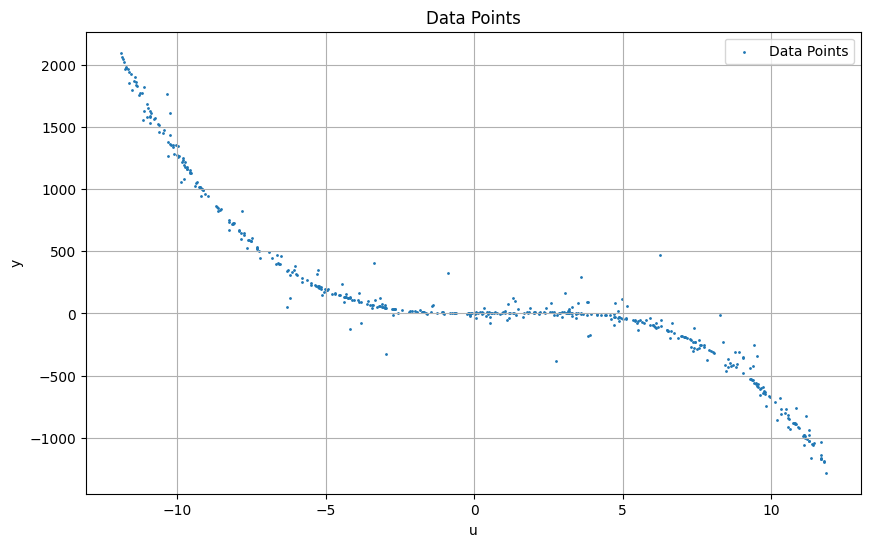

In [13]:
import numpy as np
import cvxpy as cp  # library for convex optimization
import matplotlib.pyplot as plt
# Generate sample data

## WE WILL ASSUME THIS GENERATIVE PROCESS IS UNKNOWN TO US (OFTEN THE CASE IN PRACTICE)
N = 500  # number of points
np.random.seed(42)  # for reproducibility
u = np.random.uniform(-12, 12, N)  # randomly generate u_i values in [-10, 10]
y = 2 * u + 3 * u**2 - u**3 + 20 * np.random.randn(N)**3 # corresponding y values with noise

# Plot the data points and the optimal polynomial
plt.figure(figsize=(10, 6))
plt.scatter(u, y, label='Data Points', s=1)  # Plot data points
plt.grid()
plt.xlabel('u')
plt.ylabel('y')
plt.title('Data Points')
plt.legend()
plt.show()

In [14]:
# Define the polynomial coefficients and the vertical strip width (x4)
a0 = cp.Variable()
a1 = cp.Variable()
a2 = cp.Variable()
a3 = cp.Variable()
a4 = cp.Variable(nonneg=True) # Ensure x4 is non-negative

# Define the polynomial function for each point
polynomial = a0 + a1 * u + a2 * u**2 + a3 * u**3

# Define the constraints for each data point
constraints = [cp.abs(y[i] - polynomial[i]) <= a4 for i in range(N)]

# Objective is to minimize x4
objective = cp.Minimize(a4)

# Define the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Output the results
print(f"Optimal polynomial is {a0.value} + {a1.value} * u + {a2.value} * u**2 + {a3.value} * u**3 +- {a4.value}: ")

Optimal polynomial is -44.814330283246164 + 24.480285776083143 * u + 5.587162745242576 * u**2 + -1.1606019696298626 * u**3 +- 425.8681677848708: 


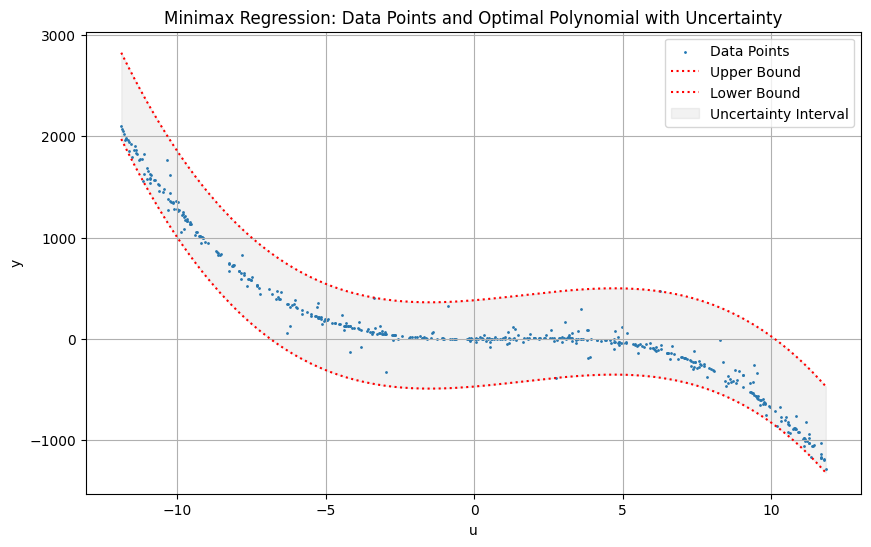

In [15]:
import matplotlib.pyplot as plt

# Create the polynomial functions
optimal_polynomial_up = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 + a4.value
optimal_polynomial_down = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 - a4.value

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(u, y, label='Data Points', s=1)  # Plot data points

# Plot the polynomials
plt.plot(np.sort(u), optimal_polynomial_up(np.sort(u)), color='red', linestyle=':', label='Upper Bound')
plt.plot(np.sort(u), optimal_polynomial_down(np.sort(u)), color='red', linestyle=':', label='Lower Bound')

# Fill the area between the upper and lower bounds
plt.fill_between(np.sort(u), optimal_polynomial_up(np.sort(u)), optimal_polynomial_down(np.sort(u)), color='gray', alpha=0.1, label='Uncertainty Interval')

# Set labels and title
plt.xlabel('u')
plt.ylabel('y')
plt.title('Minimax Regression: Data Points and Optimal Polynomial with Uncertainty')
plt.legend()
plt.grid(True)
plt.show()

Indices of active constraints: [ 92 139 260 268 285]


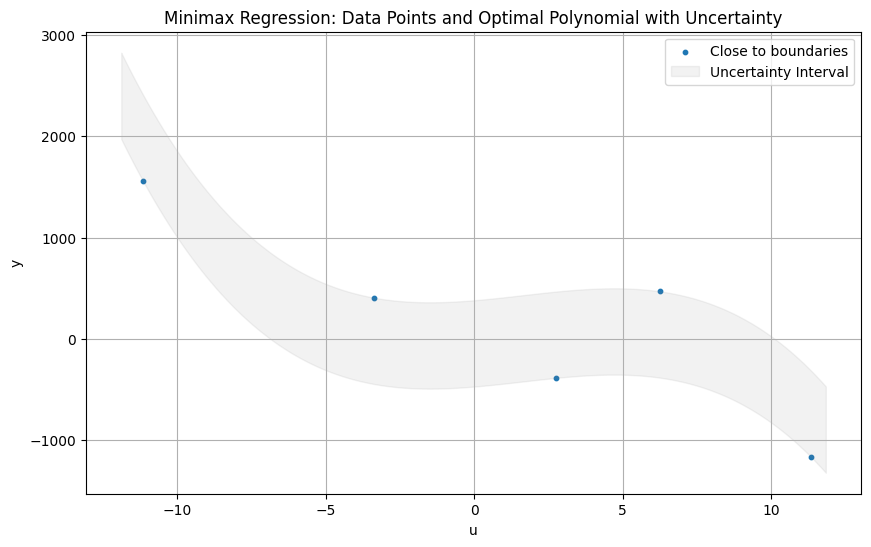

In [16]:
# find active constraints

g_fun = lambda u, y : (np.abs(y - (a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3)) - a4.value)
scores = g_fun(u,y)


active_constraints_indices = np.where(np.abs(scores) < 1e-3)[0]
print("Indices of active constraints:", active_constraints_indices)

is_close_2_boundary = np.abs(scores) < 1e-3

plt.figure(figsize=(10, 6))

plt.scatter(u[is_close_2_boundary], y[is_close_2_boundary], label='Close to boundaries', s=10)  # Plot data points

# Fill the area between the upper and lower bounds
plt.fill_between(np.sort(u), optimal_polynomial_up(np.sort(u)), optimal_polynomial_down(np.sort(u)), color='gray', alpha=0.1, label='Uncertainty Interval')

# Set labels and title
plt.xlabel('u')
plt.ylabel('y')
plt.title('Minimax Regression: Data Points and Optimal Polynomial with Uncertainty')
plt.legend()
plt.grid(True)
plt.show()

One would like to have a strip of small width so as to make a tight prediction, while keeping low the probability of not capturing the next unseen y, that is the probability of predicting correctly new sampels:

$$\mathbb{P}[(u,y) \in [f(u)- a_4, f(u)- a_4]]$$

of a new sample falling
outside the strip is small.

In [17]:
y, u = y[is_close_2_boundary==False], u[is_close_2_boundary==False]

N = len(u)

# Define the polynomial coefficients and the vertical strip width (x4)
a0 = cp.Variable()
a1 = cp.Variable()
a2 = cp.Variable()
a3 = cp.Variable()
a4 = cp.Variable(nonneg=True) # Ensure x4 is non-negative

# Define the polynomial function for each point
polynomial = a0 + a1 * u + a2 * u**2 + a3 * u**3

# Define the constraints for each data point
constraints = [cp.abs(y[i] - polynomial[i]) <= a4 for i in range(N)]

# Objective is to minimize x4
objective = cp.Minimize(a4)

# Define the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Output the results
print(f"Optimal polynomial is {a0.value} + {a1.value} * u + {a2.value} * u**2 + {a3.value} * u**3 +- {a4.value}: ")




Optimal polynomial is 35.05281449038083 + 34.729631620294995 * u + 2.6521436411897854 * u**2 + -1.3523451040277685 * u**3 +- 316.20237732384214: 


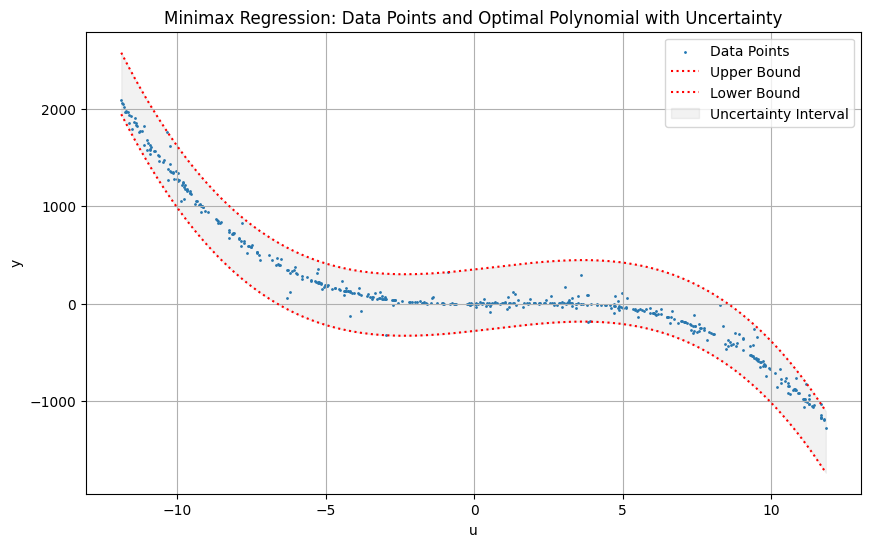

In [18]:
# Create the polynomial functions
optimal_polynomial_up = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 + a4.value
optimal_polynomial_down = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 - a4.value

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(u, y, label='Data Points', s=1)  # Plot data points

# Plot the polynomials
plt.plot(np.sort(u), optimal_polynomial_up(np.sort(u)), color='red', linestyle=':', label='Upper Bound')
plt.plot(np.sort(u), optimal_polynomial_down(np.sort(u)), color='red', linestyle=':', label='Lower Bound')

# Fill the area between the upper and lower bounds
plt.fill_between(np.sort(u), optimal_polynomial_up(np.sort(u)), optimal_polynomial_down(np.sort(u)), color='gray', alpha=0.1, label='Uncertainty Interval')

# Set labels and title
plt.xlabel('u')
plt.ylabel('y')
plt.title('Minimax Regression: Data Points and Optimal Polynomial with Uncertainty')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Generate sample data
N = 1_000  # number of points
np.random.seed(42)  # for reproducibility
u = np.random.uniform(-20, 20, N)  # randomly generate u_i values in [-10, 10]
y = 2 * u + 3 * u**2 - u**3 + 20 * np.random.randn(N)**5 # corresponding y values with noise

In [44]:
def identify_minmax_IPM(data):
  u, y = data[0], data[1]
  plt.figure(figsize=(10, 6))
  for step in range(5):

      N = len(u)

      # Define the polynomial coefficients and the vertical strip width (x4)
      a0 = cp.Variable()
      a1 = cp.Variable()
      a2 = cp.Variable()
      a3 = cp.Variable()
      a4 = cp.Variable(nonneg=True) # Ensure x4 is non-negative

      polynomial = a0 + a1 * u + a2 * u**2 + a3 * u**3  # Define the polynomial function for each point

      # Define the constraints for each data point
      constraints = [cp.abs(y[i] - polynomial[i]) <= a4 for i in range(N)]

      objective = cp.Minimize(a4)  # Objective is to minimize x4

      # Define the problem
      problem = cp.Problem(objective, constraints)

      # Solve the problem
      problem.solve()

      # Output the results
      print(f"Optimal polynomial is {a0.value} + {a1.value} * u + {a2.value} * u**2 + {a3.value} * u**3 +- {a4.value}: ")


      # remove samples
      print('removing boundary constraints')
      g_fun = lambda u, y : (np.abs(y - (a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3)) - a4.value)
      scores = g_fun(u,y)
      is_close_2_boundary = np.abs(scores) <= 1e-3


      # Create the plot
      if step==0:
         plt.scatter(u, y, label='Data Points', s=1)  # Plot data points

      plt.scatter(u[is_close_2_boundary], y[is_close_2_boundary], label='Close to boundaries', s=10, c='r')  # Plot data points

      y, u = y[is_close_2_boundary==False], u[is_close_2_boundary==False]

      # Create the polynomial functions
      optimal_polynomial_up = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 + a4.value
      optimal_polynomial_down = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 - a4.value

      # Fill the area between the upper and lower bounds
      plt.fill_between(np.sort(u), optimal_polynomial_up(np.sort(u)), optimal_polynomial_down(np.sort(u)), color='gray', alpha=0.1, label='Uncertainty Interval')
      plt.xlabel('u')
      plt.ylabel('y')
      plt.title('Minimax Regression: Data Points and Optimal Polynomial with Uncertainty')
      plt.legend()
      plt.grid(True)
  plt.show()


Optimal polynomial is 1850.8155432789092 + 12.337719044919107 * u + -10.850113407538656 * u**2 + -1.046064308200658 * u**3 +- 4965.723791057716: 
removing boundary constraints
Optimal polynomial is 221.45352528912093 + -177.90385065224447 * u + -0.09178271808816978 * u**2 + -0.3611943037698992 * u**3 +- 3061.3276881923603: 
removing boundary constraints
Optimal polynomial is 73.46898959403885 + -181.1779727117806 * u + 2.0020444826324373 * u**2 + -0.31160528935226234 * u**3 +- 2794.651821359594: 
removing boundary constraints
Optimal polynomial is 286.28167332929644 + -152.1300458140771 * u + 1.3870048877286212 * u**2 + -0.44847157923376957 * u**3 +- 2249.8433253659578: 
removing boundary constraints
Optimal polynomial is 338.36472805801674 + -61.03842504577904 * u + 2.3780966517064193 * u**2 + -0.865437841947977 * u**3 +- 1392.7715026084027: 
removing boundary constraints


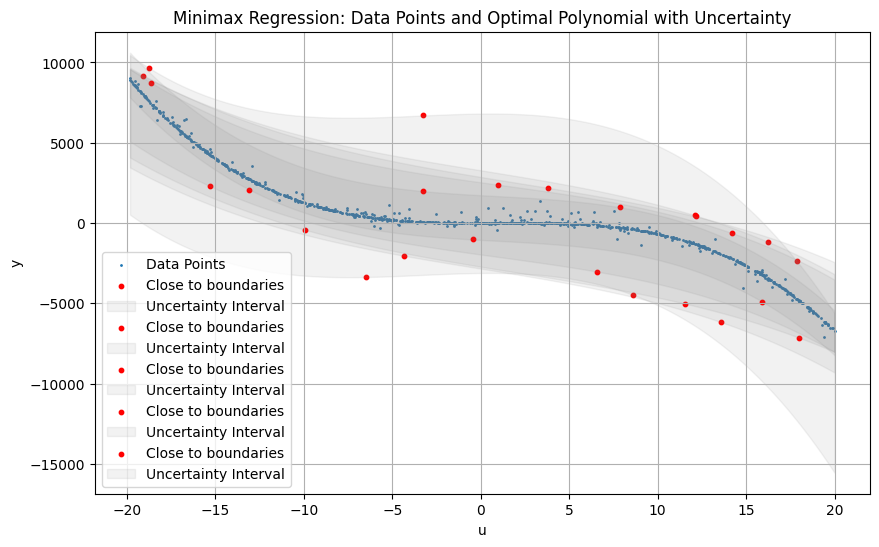

In [45]:
identify_minmax_IPM([u,y])